In [2]:
import cv2
import numpy as np
import imutils
from imutils.perspective import four_point_transform
from imutils import contours

from PIL import Image


In [46]:
def detect_players_base(frame):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    # setting threshold of gray image
    canny_high, _ = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    canny_low = 0.5 * canny_high
    clevr_canny = cv2.Canny(gray, canny_low, canny_high, 9)
    clevr_canny = cv2.morphologyEx(clevr_canny, cv2.MORPH_CLOSE, kernel = np.ones((3, 3),np.uint8))
    cnts = cv2.findContours(clevr_canny.copy(), cv2.RETR_EXTERNAL,
	cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    cnts = sorted(cnts, key=cv2.contourArea, reverse=True)
    displayCnt = None
    # loop over the contours
    founded_rectangles = 0
    rectangles = []
    
    for c in cnts:
        # approximate the contour
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.02 * peri, True)
        # if the contour has four vertices, then we have found rectangle
        if len(approx) == 4:
            founded_rectangles += 1
            rectangle = four_point_transform(frame, approx.reshape(4, 2))
            rectangles.append(rectangle)
            if founded_rectangles == 2:
                break
    # if any rectangle has first shape < 300 -> wrong figure captured || both rectangles were not found -> return None
    if any(figure.shape[0] < 300 for figure in rectangles) or len(rectangles) != 2:
        return None
    
    # sort w.r.t size of the rectangle (1. blue; 2. red)
    sorted_rectangles = sorted(rectangles, key=lambda x: x.shape[0], reverse=False)
    return tuple(sorted_rectangles)

In [47]:
def detect_cards(frame, margin: int=15):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    # gray = gray[margin:-margin, margin:-margin]
    T, thresh_image = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    kernel = np.ones(shape=(5,5))
    dilated = cv2.erode(thresh_image, kernel, iterations=1)
    
    inversed = cv2.bitwise_not(dilated)
    cv2.floodFill(inversed, None, (0,0), 255)
    cv2.floodFill(inversed, None, (0,0), 0)
    inversed = inversed[margin:-margin, margin:-margin]
    
    kernel = np.ones(shape=(3,3))
    
    inversed = cv2.morphologyEx(inversed, cv2.MORPH_CLOSE, kernel)
    contours, _ = cv2.findContours(inversed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    scopy = frame.copy()
    scopy = scopy[margin:-margin, margin:-margin]
    
    
    for cnt in contours:
        min_rect = cv2.minAreaRect(cnt)
        box = cv2.boxPoints(min_rect)
        box = np.int0(box)
        if cv2.contourArea(box) > 5000 and cv2.contourArea(box) < 10000:
            cv2.drawContours(scopy, [box], -1, (0, 255, 0), 1)    
    return scopy

In [56]:
cv2.WINDOW_AUTOSIZE = True

def run_simulation(video_path: str) -> None:
    cap = cv2.VideoCapture(video_path)
    # Simulation frame by frame
    while(True):
    # Grab the latest image from the video feed
        ret, frame = cap.read()
        # frame = cv2.resize(frame, None, None, fx=0.5, fy=0.5)
        if ret:
            bases = detect_players_base(frame)
            if bases:
                blue_player_base, red_player_base = bases
                red_cards = detect_cards(red_player_base)
                blue_cards = detect_cards(blue_player_base)
                cv2.imshow("blue_base", blue_cards)
                cv2.imshow("red_base", red_cards)
            cv2.imshow("frame", frame)

            res = cv2.waitKey(1)

            # Stop if the user presses "q"
            if res & 0xFF == ord('q'):
                break
        else: break

# When everything is done, release the capture
    cap.release()
    cv2.destroyAllWindows()

In [57]:
run_simulation("data/easy/catan_easy_1.mp4")

Above method detect red and blue rectangles in video which holds cards owned by each player. Below there are several screenshots of detected rectangles. Those frames will be processed to obtain information about number of owned cards and their types.

In [3]:
card_1 = cv2.imread("data/screenshots/blue_base_1.png")
card_2 = cv2.imread("data/screenshots/red_base_1.png")
card_3 = cv2.imread("data/screenshots/red_base_2.png")
card_4 = cv2.imread("data/screenshots/red_base_3.png")


In [4]:
def imshow(images: np.array) -> None:
    """Display images in jupyter notebook

    :param images: array with images
    :type images: np.array
    """
    images = images.clip(0, 255).astype('uint8')
    if images.ndim == 3:
        if images.shape[2] == 4:
            images = cv2.cvtColor(images, cv2.COLOR_BGRA2RGBA)
        else:
            images = cv2.cvtColor(images, cv2.COLOR_BGR2RGB)
    display(Image.fromarray(images))

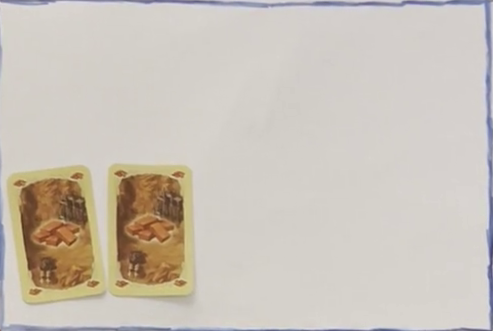

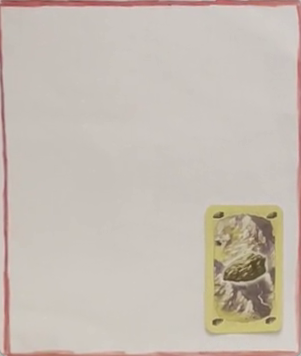

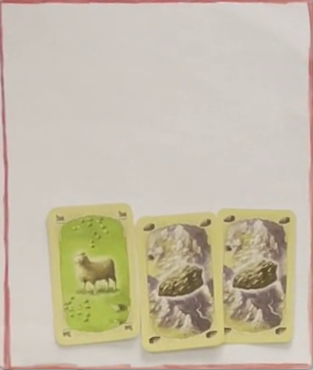

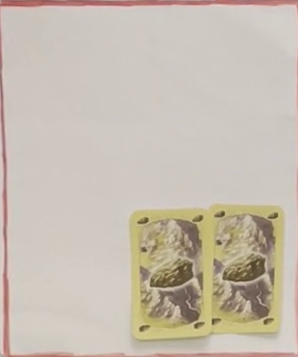

In [5]:
imshow(card_1)
imshow(card_2)
imshow(card_3)
imshow(card_4)


In [35]:
def detect_and_draw_contours(image) -> np.array:
    image_copy = image.copy()
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # setting threshold of gray image
    canny_high, _ = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    canny_low = 0.5 * canny_high
    clevr_canny = cv2.Canny(gray, canny_low, canny_high, 9)
    clevr_canny = cv2.morphologyEx(clevr_canny, cv2.MORPH_CLOSE, kernel = np.ones((3, 3),np.uint8))
    contours, _ = cv2.findContours(gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # Draw the contours on the image
    cv2.drawContours(image_copy, contours, -1, (0, 255, 0), 3)
    return image_copy

300.0
171.0
9040.0
9002.0


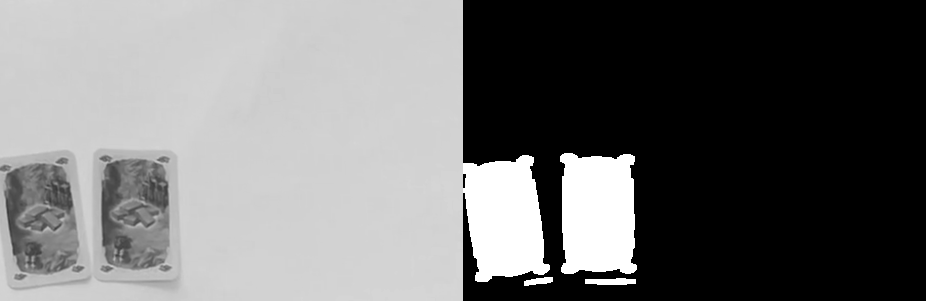

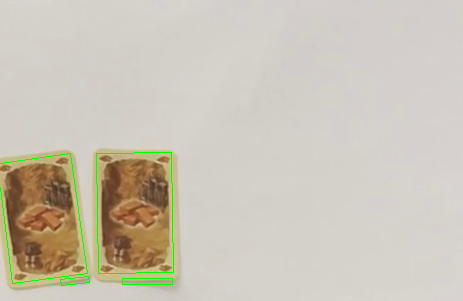

12.0
66.5
7658.0


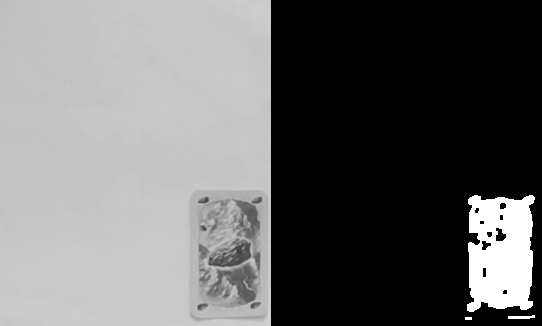

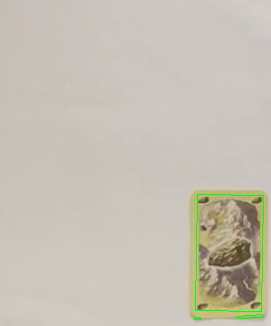

523.0
85.5
245.0
8708.0
8230.0
8960.0


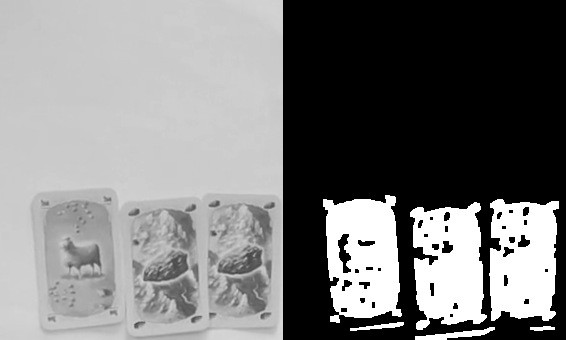

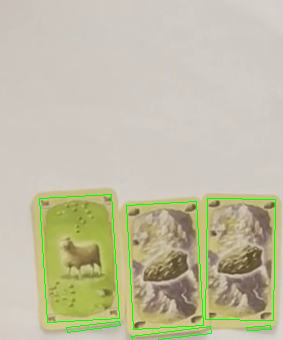

418.0
54.0
12.0
104.0
7822.0
7483.0


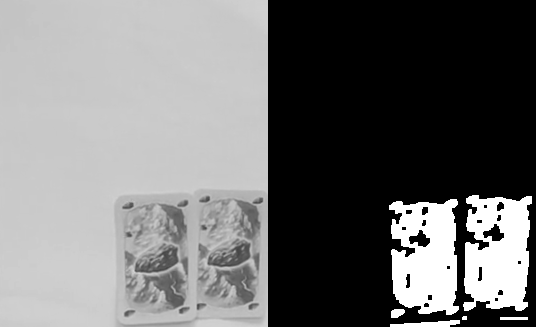

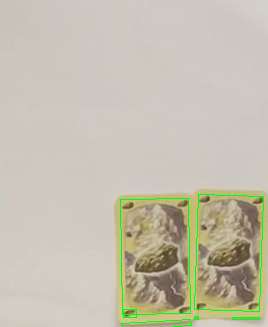

In [34]:
samples = [card_1, card_2, card_3, card_4]

kernel = np.ones(shape=(5,5))

margin = 15

for sample in samples:
    # contours_samples = detect_and_draw_contours(sample)
    
    gray = cv2.cvtColor(sample, cv2.COLOR_BGR2GRAY)
    # gray = gray[margin:-margin, margin:-margin]
    T, thresh_image = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    dilated = cv2.erode(thresh_image, kernel, iterations=1)
    contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    sample_copy = gray.copy()
    
    inversed = cv2.bitwise_not(dilated)
    cv2.floodFill(inversed, None, (0,0), 255)
    cv2.floodFill(inversed, None, (0,0), 0)
    inversed = inversed[margin:-margin, margin:-margin]
    
    kernel = np.ones(shape=(3,3))
    
    inversed = cv2.morphologyEx(inversed, cv2.MORPH_CLOSE, kernel)
    contours, _ = cv2.findContours(inversed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    scopy = sample.copy()
    scopy = scopy[margin:-margin, margin:-margin]
    
    for cnt in contours:
        min_rect = cv2.minAreaRect(cnt)
        box = cv2.boxPoints(min_rect)
        box = np.int0(box)
        print(cv2.contourArea(box))
        cv2.drawContours(scopy, [box], -1, (0, 255, 0), 1)
    
    # cv2.drawContours(sample_copy, contours, -1, (0, 255, 0), 3)
    # num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(inversed , 8 , cv2.CV_32S)
    # for i in range(num_labels):
    #     area = stats[i, cv2.CC_STAT_AREA]
    #     print(area)
    imshow(np.concatenate([gray[margin:-margin, margin:-margin],inversed], 1))
    imshow(scopy)
    